In [78]:
import rasterio
import numpy as np
import cv2
from tqdm import tqdm_notebook
from scipy import ndimage as ndi
from scipy.ndimage import gaussian_filter1d
from skimage.morphology import watershed
from skimage.morphology import skeletonize
import sknw
from shapely.geometry import LineString, Polygon
import geopandas as gpd
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [201]:
def postprocess_single_channel_pred_prod(raster_path, downscale, save_labels=True):
    connection_meters = 1
    lines_channel = 2
    with rasterio.open(raster_path, "r") as src:
        image = src.read(lines_channel)
        if src.meta['dtype'] != 'uint8':
            image = (image * 255).astype(np.uint8)
        meta = src.meta
        kernel_size = int(connection_meters / meta['transform'][0])
        if (kernel_size % 2) == 0:
            kernel_size += 1

        tree_line_mask = cv2.resize(image, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_NEAREST)

    mask = tree_line_mask > 200
    markers = tree_line_mask > 200
    energy = tree_line_mask.copy()
    energy[energy < 200] = 0
    labels = my_watershed(energy, markers, mask)
    if save_labels:
        save_meta = meta.copy()
        save_meta.update({'dtype': 'uint16',
                          'count': '1'})
        save_label_path = raster_path.replace(".tif", "_labels.tif")
        with rasterio.open(save_label_path, "w", **save_meta) as dst:
            dst.write(labels.astype(np.uint16), indexes=1)
    return labels, meta

In [27]:
def my_watershed(energy, markers, mask):
    """
    Watershed wrapper.

    :param energy: Watershed "energy" mask
    :param markers: "kernels" for the watershed algorithm
    :param mask: Binary mask separating a single class
    :return: Image with every instance labeled with a separate number.
    """
    markers = ndi.label(markers, output=np.uint32)[0]
    labels = watershed(255-energy, markers, watershed_line=True, mask=mask)
    return labels

In [28]:
def graph_to_shp_lines(graph_lines, meta, each=20, downscale=0.2, edge_length_threshold=50):
    lines = []
    for num, graph in tqdm_notebook(enumerate(graph_lines)):

        node, nodes = graph.node, graph.nodes()

        for (s, e) in graph.edges():
            ps = []
            weight = graph[s][e]['weight']
            if weight < edge_length_threshold:
                continue
            ps.append(nodes[s]['o'])
            pts = graph[s][e]['pts']
            ps.extend(pts)
            ps.append(nodes[e]['o'])
            ps = np.array(ps)

            if len(ps) > each:
                last = np.expand_dims(ps[-1], axis=0)

                ps = ps[::each]
                ps = np.append(ps, last, axis=0)

            if len(ps) < 2:
                continue
            ps = ps * 1 / downscale
            # change x and y
            ps_yx = ps.copy()
            ps_yx[:, 1] = ps[:, 0]
            ps_yx[:, 0] = ps[:, 1]
            #
            converted = [meta['transform'] * pt for pt in ps_yx]
            line = LineString(converted)
            lines.append(line)
    return lines

In [29]:
def make_lines(labels):
    graphs = []
    for num, label in tqdm_notebook(enumerate(range(1, len(np.unique(labels)) + 1)), total=len(np.unique(labels))):
        label_mask = labels == label
        ske = skeletonize(label_mask).astype(np.uint16)
        graph = sknw.build_sknw(ske)
        graphs.append(graph)

    #         if num == 100:
    #             break
    return graphs

In [191]:
def postprocess_single_channel_pred(raster_path, downscale, save_labels=False):
    connection_meters = 1
    lines_channel = 1
    with rasterio.open(raster_path, "r") as src:
        image = src.read(lines_channel)
        if src.meta['dtype'] != 'uint8':
            image = (image * 255).astype(np.uint8)
        meta = src.meta
        kernel_size = int(connection_meters / meta['transform'][0])
        if (kernel_size % 2) == 0:
            kernel_size += 1
        kernel = np.ones((kernel_size, kernel_size))
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        
        # image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        tree_line_mask = cv2.resize(image, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_NEAREST)
        
        kernel_size = int(downscale * kernel_size)
        if (kernel_size % 2) == 0:
            kernel_size += 1
            
        tree_line_mask = cv2.blur(tree_line_mask, (kernel_size, kernel_size))

    mask = tree_line_mask > 50
    markers = tree_line_mask > 50
    energy = tree_line_mask.copy()
    energy[energy < 30] = 0
    labels = my_watershed(energy, markers, mask)
    if save_labels:
        save_meta = meta.copy()
        save_meta.update({'dtype': 'uint16',
                          'count': '1'})
        save_label_path = raster_path.replace(".tif", "_labels.tif")
        with rasterio.open(save_label_path, "w", **save_meta) as dst:
            dst.write(labels.astype(np.uint16), indexes=1)
    return labels, meta

In [202]:
def run_lines_generation(raster_path, save_path, downscale=0.2, network_channels=1, crs=None, prod=False):
    if not prod:
        labels, meta = postprocess_single_channel_pred(raster_path, downscale)
    else:
        labels, meta = postprocess_single_channel_pred_prod(raster_path, downscale)


    # creating lines
    graph_lines = make_lines(labels)
    return graph_lines
    

In [113]:
def gaussian_smooth_geom(geom, sigma=2, num_points_factor=2, mode='wrap'):
    if isinstance(geom, (Polygon, LineString)):
        if type(geom) == LineString:
            x, y = gaussian_smooth(geom.coords, sigma, num_points_factor, mode)
            return LineString(list(zip(x, y)))

        elif type(geom) == Polygon:
            x, y = gaussian_smooth(geom.exterior.coords, sigma, num_points_factor, mode)
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            if len(list(geom.interiors)) > 0:
                l = []
                l.append(list(zip(x, y)))

                for interior in list(geom.interiors):
                    x, y = gaussian_smooth(interior, sigma, num_points_factor, mode)
                    l.append(list(zip(x, y)))
                return Polygon([item for sublist in l for item in sublist])
            else:

                return Polygon(list(zip(x, y)))

    elif isinstance(geom, (MultiPolygon, MultiLineString)):
        list_ = []
        for g in geom:
            list_.append(gaussian_smooth_geom(g, sigma, num_points_factor, mode))

        if type(geom) == MultiPolygon:

            return MultiPolygon(list_)
        else:
            return MultiLineString(list_)
    else:
        logging.warning(
            'geometry must be LineString, Polygon, MultiLineString or MultiPolygon, returning original geometry')
        return geom

In [55]:
def save_gpd_df(save_path, geom_df, crs=None, meta=None):
    if meta:
        geom_df.crs = meta.get('crs')
    if os.path.exists(save_path):
        os.remove(save_path)
    if crs:
        geom_df = geom_df.to_crs(epsg=crs)
    geom_df.to_file(save_path, driver='GeoJSON', encoding='utf-8')


In [104]:
def gaussian_smooth(coords, sigma=2, num_points_factor=2, mode='wrap'):
    coords = np.array(coords)
    x, y = coords.T
    xp = np.linspace(0, 1, coords.shape[0])
    interp = np.linspace(0, 1, coords.shape[0] * num_points_factor)
    x = np.interp(interp, xp, x)
    y = np.interp(interp, xp, y)
    x = np.pad(x, sigma + 6 * num_points_factor, mode='edge' )
    y = np.pad(y, sigma + 6 * num_points_factor, mode='edge')
    x = gaussian_filter1d(x, sigma, mode=mode)
    y = gaussian_filter1d(y, sigma, mode=mode)
    return x, y

In [194]:
raster_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/job_results/bugs/1-37/distance_mask.tif"
save_label_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/job_results/bugs/1-37/labels_50_op.tif"
save_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/job_results/bugs/1-37/lines_10_distances.geojson"
downscale = 0.2

In [220]:
raster_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_resnet_1570_256_tuned_lines/project_transparent_mosaic_rgb_bin.tif"
save_label_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_resnet_1570_256_tuned_lines/labels_50_op.tif"
save_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/rio_grande/58809/dist_net_resnet_1570_256_tuned_lines/lines_prod.geojson"
downscale = 0.2

In [221]:
graph_lines = run_lines_generation(raster_path, save_path, downscale=downscale, network_channels=1, crs=None, prod=True)

In [223]:
labels, meta = postprocess_single_channel_pred(raster_path, downscale=0.2)

In [224]:
# transforming lines to shapely objects
lines = graph_to_shp_lines(graph_lines, meta, each=5, downscale=downscale)
line_gdf = gpd.GeoDataFrame(geometry=lines)
line_gdf['geometry'] = line_gdf['geometry'].apply(lambda x: gaussian_smooth_geom(x,
                                                                                 sigma=20,
                                                                                 num_points_factor=5,
                                                                                 mode='nearest'))
# simplify
line_gdf['geometry'] = line_gdf['geometry'].apply(lambda x: x.simplify(0.1))
line_gdf['id'] = np.arange(len(line_gdf))
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_gpd_df(save_path, line_gdf, meta=meta)

In [196]:
save_meta = meta.copy()
save_meta.update({'dtype': 'uint16',
                  'count': '1'})
#save_label_path = raster_path.replace(".tif", "_labels.tif")

with rasterio.open(save_label_path, "w", **save_meta) as dst:
    dst.write(labels.astype(np.uint16), indexes=1)

In [76]:
len(line_gdf_no_smooth.values[0][0].coords)

12

In [75]:
len(line_gdf.values[0][0].coords)

3

In [80]:
np.array(line_gdf.values[0][0].coords)

array([[ 707137.28122301, 7467767.26861236],
       [ 707140.03775787, 7467762.30746868],
       [ 707150.17405668, 7467745.95541496]])

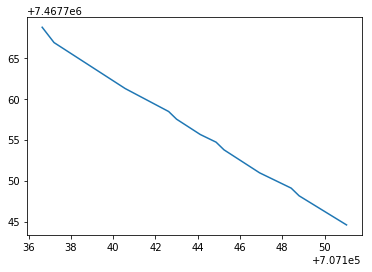

In [83]:
plt.plot(np.array(line_gdf_no_smooth.values[0][0].coords)[:, 0], np.array(line_gdf_no_smooth.values[0][0].coords)[:, 1])

In [85]:
np.array(line_gdf_no_smooth.values[0][0].coords)[:, 0][0]

707136.6432400001

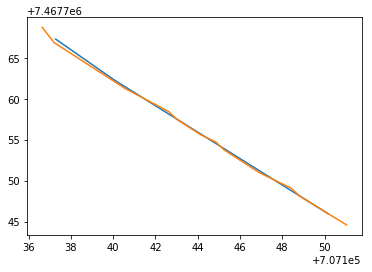

In [87]:
plt.plot(np.array(line_gdf.values[0][0].coords)[:, 0], np.array(line_gdf.values[0][0].coords)[:, 1])
plt.plot(np.array(line_gdf_no_smooth.values[0][0].coords)[:, 0], np.array(line_gdf_no_smooth.values[0][0].coords)[:, 1])

In [86]:
np.array(line_gdf.values[0][0].coords)[:, 0][0]

707137.2812230142